In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
import time


In [308]:
import re
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from wordcloud import WordCloud


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS


In [2]:
from sqlalchemy import create_engine
#engine = create_engine('sqlite://', echo=False)
#engine = create_engine('sqlite:////Users/monikabagyal/Google_drive_minsifye/Courses/Spring2020/InnovationAnalytics/GroupProject/', echo=False)

sql_engine = create_engine('sqlite:///test.db', echo=False)
connection = sql_engine.raw_connection()


In [3]:
skytrax = pd.read_excel("skytrax.xlsx")
skytrax.head()

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01,4.0,5.0,4.0,4.0,2.0,4.0,yes
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01,4.0,1.0,1.0,1.0,1.0,1.0,no
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Working with only US Domestic Airlines

In [4]:
skytrax = skytrax[skytrax['airline'].isin(['American Airlines', 'Delta Air Lines', 'Southwest Airlines', 'United Airlines','Jetblue Airways', 'Frontier Airlines', 'Spirit Airlines'])]
skytrax.reset_index(inplace=True)
skytrax.drop('index', inplace=True, axis=1)
skytrax.head()

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,American Airlines,5.0,B Merton,11th May 2019,âœ… Trip Verified | We were scheduled to fly f...,Boeing 737-8,Couple Leisure,First Class,Miami to Orlando,2019-05-01,5.0,5.0,5.0,NaN,3.0,3.0,no
1,American Airlines,1.0,Dave Benton,10th May 2019,Not Verified | I had a flight from Dallas to S...,Boeing 737-800,Family Leisure,Premium Economy,Dallas to San Diego,2019-05-01,1.0,2.0,2.0,2.0,1.0,1.0,no
2,American Airlines,1.0,J Richard,10th May 2019,Not Verified | Pittsburgh to Tampa. Every sing...,NaN,Family Leisure,Economy Class,Pittsburgh to Tampa,2019-04-01,1.0,1.0,NaN,NaN,1.0,1.0,no
3,American Airlines,1.0,G Meares,9th May 2019,âœ… Trip Verified | Dallas to Atlanta. You hav...,NaN,Business,Economy Class,Dallas to Atlanta,2019-05-01,3.0,2.0,1.0,1.0,1.0,1.0,no
4,American Airlines,3.0,S Klein,8th May 2019,âœ… Trip Verified | Tampa to Vancouver via Dal...,NaN,Couple Leisure,Economy Class,Tampa to Vancouver via Dallas,2019-05-01,1.0,1.0,1.0,3.0,1.0,1.0,no


In [5]:
print("Total rows:",skytrax.shape[0])
skytrax.airline.value_counts()

Total rows: 13359


Spirit Airlines       2934
American Airlines     2867
United Airlines       2829
Frontier Airlines     1624
Delta Air Lines       1547
Southwest Airlines     913
Jetblue Airways        645
Name: airline, dtype: int64

# Total Customer Reviews for Each Airline

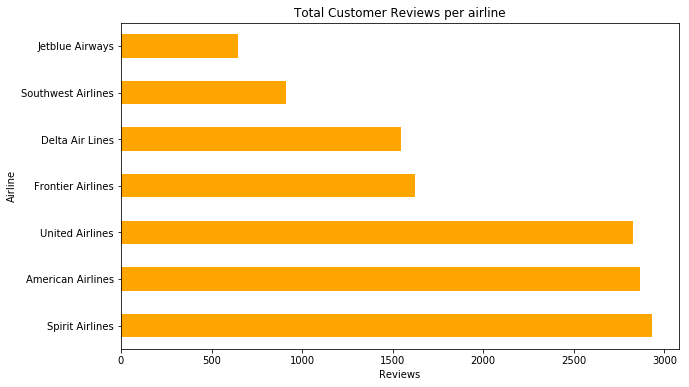

In [6]:
skytrax.airline.value_counts().plot(kind='barh', title='Total Customer Reviews per airline', figsize=(10,6), color='orange');
plt.xlabel('Reviews')
plt.ylabel('Airline');
#plt.savefig('plot1.png', bbox_inches = 'tight');

### Percentage of missing values per column 

In [7]:
np.sum(skytrax.isnull())/skytrax.shape[0]

airline            0.000000
overall            0.028071
author             0.000000
review_date        0.000000
customer_review    0.000000
aircraft           0.833820
traveller_type     0.277117
cabin              0.094768
route              0.277940
date_flown         0.278838
seat_comfort       0.062205
cabin_service      0.059361
food_bev           0.299948
entertainment      0.413504
ground_service     0.283180
value_for_money    0.027397
recommended        0.023804
dtype: float64

## Dropping Aircraft and Route column

In [8]:
skytrax = skytrax[['airline', 'overall', 'author', 'review_date', 'customer_review',
       'traveller_type', 'cabin', 'date_flown',
       'seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money', 'recommended']]
# Keeping a copy of skytrax dataset in case needed later
old_skytrax = skytrax.copy()

# Handling Missing Values
### these columns seat_comfort	cabin_service	food_bev	entertainment	ground_service	value_for_money	need to be filled with mean() value

In [9]:
skytrax[['seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money']] = skytrax[['seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money']].apply(lambda row: row.fillna(row.mean()), axis=1)

skytrax[['seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money']] = skytrax[['seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money']].apply(lambda row: row.fillna(0), axis=1)

skytrax[['overall', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money']] = skytrax[['overall', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money']].apply(lambda row: row.fillna(row.mean()), axis=1)

# Let's check percentage of missing value in dataset
(np.sum(skytrax.isnull())/skytrax.shape[0])*100

airline             0.000000
overall             0.000000
author              0.000000
review_date         0.000000
customer_review     0.000000
traveller_type     27.711655
cabin               9.476757
date_flown         27.883824
seat_comfort        0.000000
cabin_service       0.000000
food_bev            0.000000
entertainment       0.000000
ground_service      0.000000
value_for_money     0.000000
recommended         2.380418
dtype: float64

## Let's look in to one data row with some NuLL values

In [10]:
# Index 25 has been identified for this task
# Index 25 has Null value for cabin data
print(skytrax.ix[25].customer_review)
skytrax.ix[25]

âœ… Trip Verified | Cancun to Milan via Miami. We were six counting a handicap person and an infant (2 years). Our flight took off delayed of one hour from Cancun, when we finally arrived in MIA we had only about 1 hour to the connection. So then the 1st soap opera began, no one came to take my stepfather (the handicap) at the plane, after 10 min some one came and left him at a place with others, then the lady from AA said we should reschedule our flight home for the other day, after a brief discussion she called someone and he and my mother went one way and my sister, niece and brother in law in another. We used the APC (Automated Passport Control) and went to the line, or should i say lines, i went one way. then security control. We all met after SC and went to the gate, there the second soap opera began. apparently some battery had to be changed and after multiple delays, emails, and texts and about 3 hours waiting later they decided to change the airplane, so we had to change gates

/Users/monikabagyal/anaconda3/envs/mona/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


airline                                            American Airlines
overall                                                            1
author                                    Luis Eduardo Vieira mendes
review_date                                          28th April 2019
customer_review    âœ… Trip Verified | Cancun to Milan via Miami....
traveller_type                                                   NaN
cabin                                                            NaN
date_flown                                                       NaT
seat_comfort                                                       0
cabin_service                                                      0
food_bev                                                           0
entertainment                                                      0
ground_service                                                     0
value_for_money                                                    0
recommended                       

In [14]:
# Possible values in traveller_type column
print(skytrax['traveller_type'].value_counts())
# Possible values in traveller_type column
print('\n',skytrax['cabin'].value_counts())
# Possible values in recommended column
print('\n',skytrax['recommended'].value_counts())

Solo Leisure      3229
Couple Leisure    2431
Family Leisure    2321
Business          1676
Name: traveller_type, dtype: int64

 Economy Class      10341
Business Class       656
Premium Economy      549
First Class          547
Name: cabin, dtype: int64

 no     9871
yes    3170
Name: recommended, dtype: int64


In [15]:
# Date type
skytrax['review_date'].head(5)

0    11th May 2019
1    10th May 2019
2    10th May 2019
3     9th May 2019
4     8th May 2019
Name: review_date, dtype: object

In [16]:
# splitting review_date column to get month and year value in separate columns
ignore, skytrax['review_month'], skytrax['review_year'] = skytrax['review_date'].str.split(' ').str

look_up = {'January': 1, 'February':2, 'March':3, 'April':4, 'May':5,
            'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}

skytrax['review_month'] = skytrax['review_month'].apply(lambda x: look_up[x])

# Changing datatype of review_year column
skytrax['review_year'] = skytrax['review_year'].apply(lambda x:int(x))



In [17]:
skytrax = skytrax[['airline', 'overall', 'customer_review',
       'traveller_type', 'cabin', 'seat_comfort',
       'cabin_service', 'food_bev', 'entertainment', 'ground_service',
       'value_for_money', 'recommended', 'review_month', 'review_year']]
skytrax = skytrax.fillna('Null')

,Avg_Rating
airline,
Southwest Airlines,5.065991
Jetblue Airways,4.926253
Delta Air Lines,4.536436
United Airlines,3.028279
American Airlines,2.896843
Spirit Airlines,2.607277
Frontier Airlines,2.298327


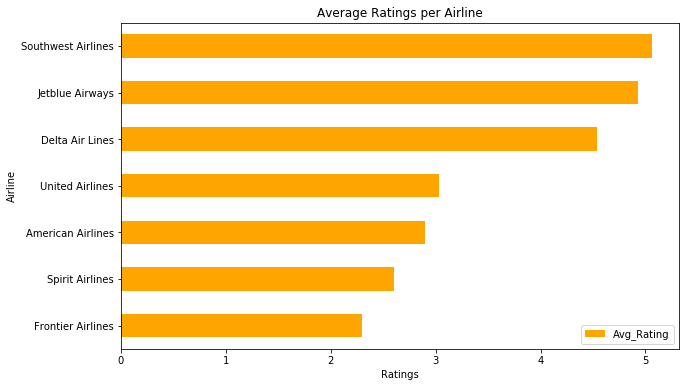

In [23]:
sky_mean = skytrax[['airline', 'overall']].groupby('airline').mean()
sky_mean.columns = ['Avg_Rating']
sky_mean.sort_values('Avg_Rating').plot(kind='barh', title='Average Ratings per Airline', figsize=(10,6), color='orange');
plt.xlabel('Ratings')
plt.ylabel('Airline');
sky_mean.sort_values('Avg_Rating', ascending=False)



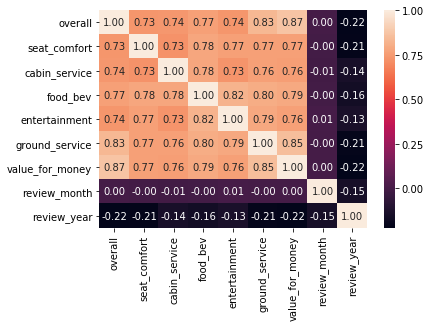

In [24]:
sns.heatmap(skytrax.corr(), annot=True, fmt='.2f');


In [25]:
skytrax.describe()

,overall,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,review_month,review_year
count,13359.000000,13359.000000,13359.000000,13359.000000,13359.000000,13359.000000,13359.000000,13359.000000,13359.000000
mean,3.224420,2.154421,2.378309,2.009423,2.037333,2.043731,2.063989,6.382065,2016.263942
std,3.227973,1.404589,1.564284,1.360926,1.420619,1.451273,1.521475,3.357431,1.830220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2010.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2015.000000
50%,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,6.000000,2016.000000
75%,5.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,9.000000,2018.000000
max,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,12.000000,2019.000000


In [29]:
skytrax_modified = pd.get_dummies(skytrax.drop(['customer_review', 'airline'], axis=1))

In [30]:
skytrax_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13359 entries, 0 to 13358
Data columns (total 22 columns):
overall                          13359 non-null float64
seat_comfort                     13359 non-null float64
cabin_service                    13359 non-null float64
food_bev                         13359 non-null float64
entertainment                    13359 non-null float64
ground_service                   13359 non-null float64
value_for_money                  13359 non-null float64
review_month                     13359 non-null int64
review_year                      13359 non-null int64
traveller_type_Business          13359 non-null uint8
traveller_type_Couple Leisure    13359 non-null uint8
traveller_type_Family Leisure    13359 non-null uint8
traveller_type_Null              13359 non-null uint8
traveller_type_Solo Leisure      13359 non-null uint8
cabin_Business Class             13359 non-null uint8
cabin_Economy Class              13359 non-null uint8
cabin_First C

# Let's Predict Recommended column's 2.3% Missing values based on other columns: Random Forest Classifier

In [33]:
df_train = skytrax_modified[skytrax_modified['recommended_Null'] == 0]
df_test = skytrax_modified[skytrax_modified['recommended_Null'] == 1]

In [34]:
df_train.corr().head(1).transpose()

,overall
overall,1.000000
seat_comfort,0.764898
cabin_service,0.773906
food_bev,0.796085
entertainment,0.766282
ground_service,0.865788
value_for_money,0.902727
review_month,0.000996
review_year,-0.219770
traveller_type_Business,-0.062490


### Splitting Dataset into training and testing sets.

In [59]:
X = df_train.drop(['review_year', 'review_month','recommended_Null', 'recommended_no', 'cabin_Null', 'traveller_type_Null', 'recommended_yes'], axis=1)
y = df_train['recommended_yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


### Logistic Regression 

In [60]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98      1962
          1       0.95      0.94      0.94       647

avg / total       0.97      0.97      0.97      2609

[[1928   34]
 [  42  605]]


### Random Forest Classifier

In [61]:

rfc = RandomForestClassifier(n_estimators=300)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))



             precision    recall  f1-score   support

          0       0.98      0.98      0.98      1962
          1       0.95      0.93      0.94       647

avg / total       0.97      0.97      0.97      2609

[[1929   33]
 [  45  602]]


### both models perform similar, let's choose logistic regression model

In [64]:
X_prod = df_test.drop(['review_year', 'review_month', 'recommended_Null', 'recommended_no', 'cabin_Null', 'traveller_type_Null', 'recommended_yes'], axis=1)
recommended_category = logmodel.predict(X_prod)

recommended_category


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### As few values of recommended column got prediction as 1, we need to make changes to final recommend column. Only recommended_yes column will be considered to see if reviewers recommend the airline or not.

In [172]:
counter = 0
start = time.process_time()
for index_point in df_test.index.base:
    #print(index_point)
    skytrax_modified['Recom'].iat[index_point] = recommended_category[counter]
    counter +=1
    

timeTaken = time.process_time() - start
print('timeTaken:',timeTaken)



timeTaken: 0.003254999999995789


In [177]:
skytrax_modified['recommended'] = skytrax_modified['recommended_yes'] + skytrax_modified['Recom']

In [179]:
skytrax_modified.columns

Index(['overall', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money', 'review_month', 'review_year',
       'traveller_type_Business', 'traveller_type_Couple Leisure',
       'traveller_type_Family Leisure', 'traveller_type_Null',
       'traveller_type_Solo Leisure', 'cabin_Business Class',
       'cabin_Economy Class', 'cabin_First Class', 'cabin_Null',
       'cabin_Premium Economy', 'recommended_Null', 'recommended_no',
       'recommended_yes', 'Recom', 'recommended'],
      dtype='object')

In [180]:
skytrax_modified = skytrax_modified.drop(['recommended_Null', 'recommended_no', 'recommended_yes', 'Recom','cabin_Null', 'traveller_type_Null'], axis=1)


In [181]:
skytrax_modified.head()

,overall,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,review_month,review_year,traveller_type_Business,traveller_type_Couple Leisure,traveller_type_Family Leisure,traveller_type_Solo Leisure,cabin_Business Class,cabin_Economy Class,cabin_First Class,cabin_Premium Economy,recommended
0,5.0,5.0,5.0,5.0,4.2,3.0,3.0,5,2019,0,1,0,0,0,0,1,0,0
1,1.0,1.0,2.0,2.0,2.0,1.0,1.0,5,2019,0,0,1,0,0,0,0,1,0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5,2019,0,0,1,0,0,1,0,0,0
3,1.0,3.0,2.0,1.0,1.0,1.0,1.0,5,2019,1,0,0,0,0,1,0,0,0
4,3.0,1.0,1.0,1.0,3.0,1.0,1.0,5,2019,0,1,0,0,0,1,0,0,0


In [182]:

skytrax_reviews = skytrax[['airline', 'customer_review']]



In [183]:
skytrax_reviews.head()

,airline,customer_review
0,American Airlines,âœ… Trip Verified | We were scheduled to fly f...
1,American Airlines,Not Verified | I had a flight from Dallas to S...
2,American Airlines,Not Verified | Pittsburgh to Tampa. Every sing...
3,American Airlines,âœ… Trip Verified | Dallas to Atlanta. You hav...
4,American Airlines,âœ… Trip Verified | Tampa to Vancouver via Dal...


In [184]:
skytrax_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13359 entries, 0 to 13358
Data columns (total 2 columns):
airline            13359 non-null object
customer_review    13359 non-null object
dtypes: object(2)
memory usage: 208.8+ KB


In [185]:
df_sky = pd.concat([skytrax_reviews, skytrax_modified], axis=1)

In [186]:
df_sky.head()

,airline,customer_review,overall,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,review_month,review_year,traveller_type_Business,traveller_type_Couple Leisure,traveller_type_Family Leisure,traveller_type_Solo Leisure,cabin_Business Class,cabin_Economy Class,cabin_First Class,cabin_Premium Economy,recommended
0,American Airlines,âœ… Trip Verified | We were scheduled to fly f...,5.0,5.0,5.0,5.0,4.2,3.0,3.0,5,2019,0,1,0,0,0,0,1,0,0
1,American Airlines,Not Verified | I had a flight from Dallas to S...,1.0,1.0,2.0,2.0,2.0,1.0,1.0,5,2019,0,0,1,0,0,0,0,1,0
2,American Airlines,Not Verified | Pittsburgh to Tampa. Every sing...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5,2019,0,0,1,0,0,1,0,0,0
3,American Airlines,âœ… Trip Verified | Dallas to Atlanta. You hav...,1.0,3.0,2.0,1.0,1.0,1.0,1.0,5,2019,1,0,0,0,0,1,0,0,0
4,American Airlines,âœ… Trip Verified | Tampa to Vancouver via Dal...,3.0,1.0,1.0,1.0,3.0,1.0,1.0,5,2019,0,1,0,0,0,1,0,0,0


In [236]:

look_up_airline = {'American Airlines':1, 'Delta Air Lines':2, 'Southwest Airlines':3,
           'United Airlines':4, 'Jetblue Airways':5, 'Spirit Airlines':6,'Frontier Airlines':7}

df_sky['airline_no'] = df_sky['airline'].apply(lambda x: look_up_airline[x])
df_sky[['airline', 'airline_no']].groupby('airline').mean()

,airline_no
airline,
American Airlines,1
Delta Air Lines,2
Frontier Airlines,7
Jetblue Airways,5
Southwest Airlines,3
Spirit Airlines,6
United Airlines,4


In [267]:
df_sky.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13359 entries, 0 to 13358
Data columns (total 21 columns):
airline                          13359 non-null object
customer_review                  13359 non-null object
overall                          13359 non-null float64
seat_comfort                     13359 non-null float64
cabin_service                    13359 non-null float64
food_bev                         13359 non-null float64
entertainment                    13359 non-null float64
ground_service                   13359 non-null float64
value_for_money                  13359 non-null float64
review_month                     13359 non-null int64
review_year                      13359 non-null int64
traveller_type_Business          13359 non-null uint8
traveller_type_Couple Leisure    13359 non-null uint8
traveller_type_Family Leisure    13359 non-null uint8
traveller_type_Solo Leisure      13359 non-null uint8
cabin_Business Class             13359 non-null uint8
cabin_Econo

In [268]:
# Data Cleaning completed and file stored in csv format
df_sky.to_csv('Skytrax_Modified.csv', index=False)

## Overall Ratings for each airline over the years

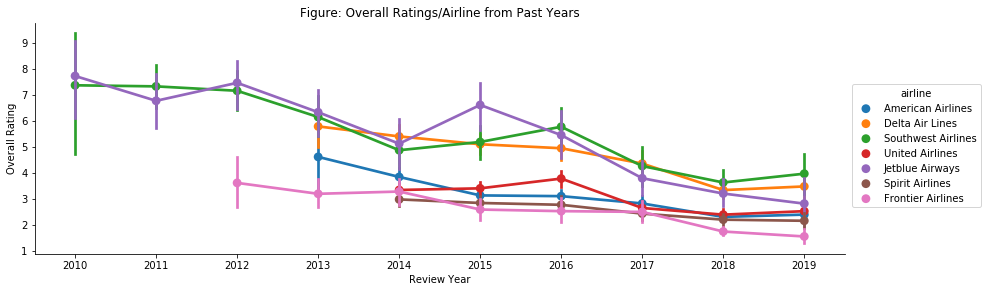

In [273]:
#plt.figure(figsize=(5,5));
sns.factorplot(x='review_year', y='overall',data=df_sky, height=6, aspect=3, hue='airline');
plt.xlabel('Review Year');
plt.ylabel('Overall Rating');
plt.title("Figure: Overall Ratings/Airline from Past Years");

In [269]:
df_sky.columns

Index(['airline', 'customer_review', 'overall', 'seat_comfort',
       'cabin_service', 'food_bev', 'entertainment', 'ground_service',
       'value_for_money', 'review_month', 'review_year',
       'traveller_type_Business', 'traveller_type_Couple Leisure',
       'traveller_type_Family Leisure', 'traveller_type_Solo Leisure',
       'cabin_Business Class', 'cabin_Economy Class', 'cabin_First Class',
       'cabin_Premium Economy', 'recommended', 'airline_no'],
      dtype='object')

## Customer Recommedation per Airline from Past Years

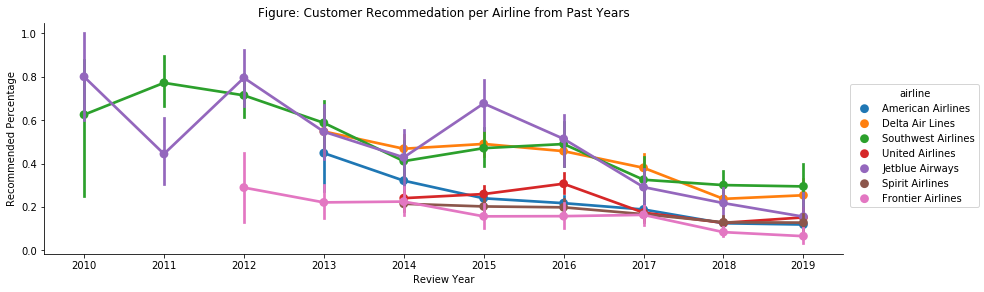

In [276]:
sns.factorplot(x='review_year', y='recommended',data=df_sky, height=6, aspect=3, hue='airline');
plt.xlabel('Review Year');
plt.ylabel('Recommended Percentage');
plt.title("Figure: Customer Recommedation per Airline from Past Years");

## Delta- United- American Airlines Ratings Graphs 

In [400]:
DUA = df_sky[df_sky['airline_no'] <5]
DUA = DUA[DUA['airline_no']!=3]

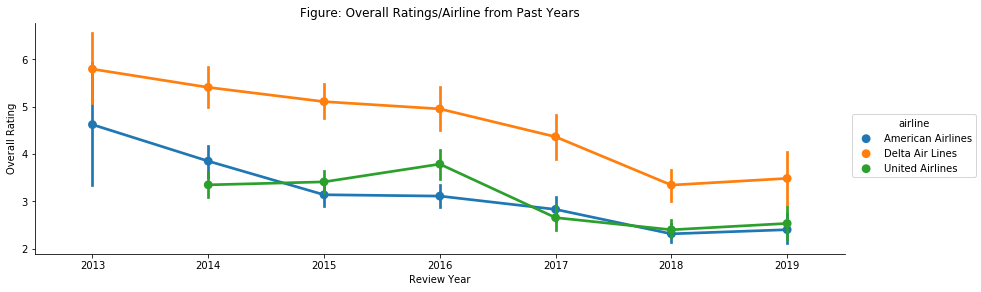

In [277]:
#plt.figure(figsize=(10,15));
sns.factorplot(x='review_year', y='overall', data=DUA , height=6, aspect=3, hue='airline', );
plt.xlabel('Review Year');
plt.ylabel('Overall Rating');
plt.title("Figure: Overall Ratings/Airline from Past Years");

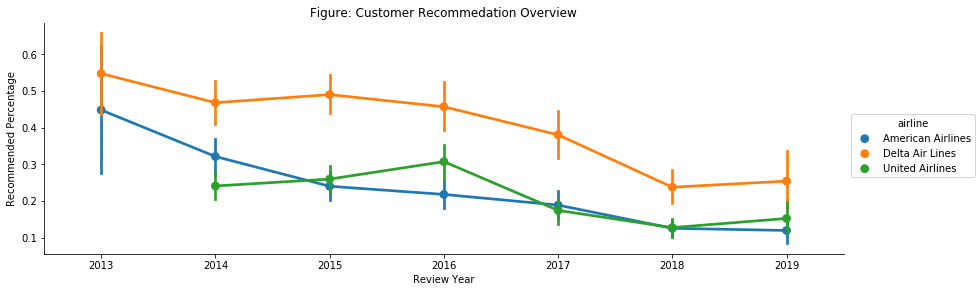

In [281]:
sns.factorplot(x='review_year', y='recommended',data=DUA, height=6, aspect=3, hue='airline');
plt.xlabel('Review Year');
plt.ylabel('Recommended Percentage');
plt.title("Figure: Customer Recommedation Overview");

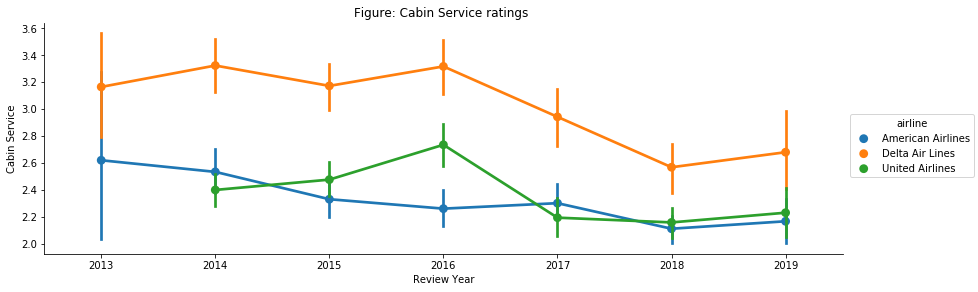

In [280]:
sns.factorplot(x='review_year', y='cabin_service',data=DUA, height=6, aspect=3, hue='airline');
plt.xlabel('Review Year');
plt.ylabel('Cabin Service');
plt.title("Figure: Cabin Service ratings ");

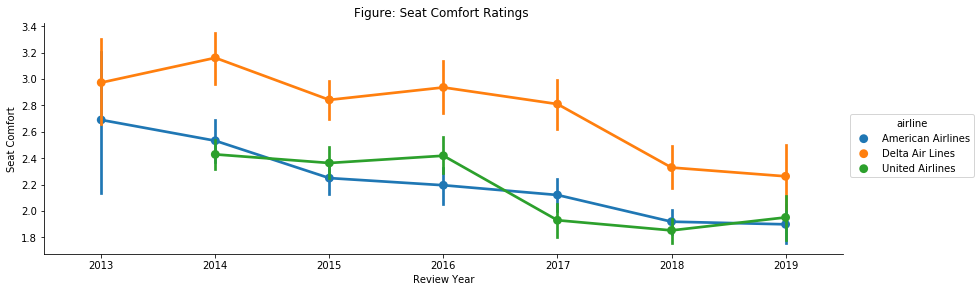

In [283]:
sns.factorplot(x='review_year', y='seat_comfort',data=DUA, height=6, aspect=3, hue='airline');
plt.xlabel('Review Year');
plt.ylabel('Seat Comfort');
plt.title("Figure: Seat Comfort Ratings ");

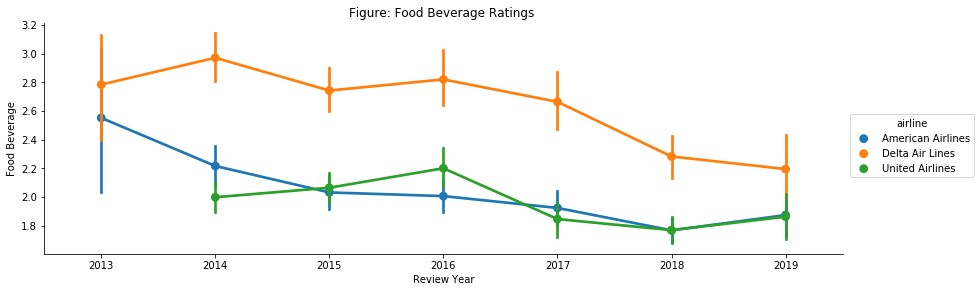

In [284]:
sns.factorplot(x='review_year', y='food_bev',data=DUA, height=6, aspect=3, hue='airline');
plt.xlabel('Review Year');
plt.ylabel('Food Beverage');
plt.title("Figure: Food Beverage Ratings ");

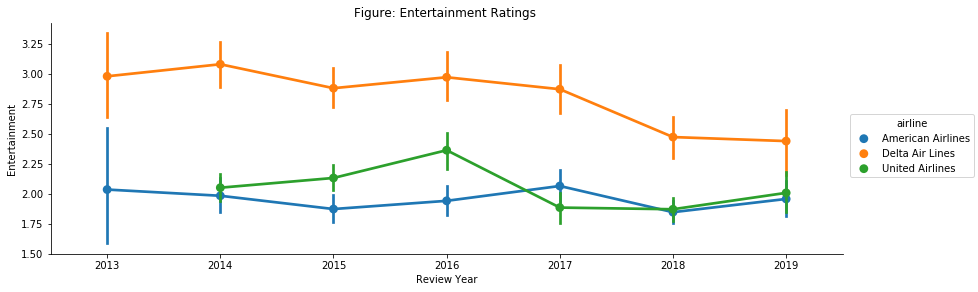

In [285]:
sns.factorplot(x='review_year', y='entertainment',data=DUA, height=6, aspect=3, hue='airline');
plt.xlabel('Review Year');
plt.ylabel('Entertainment');
plt.title("Figure: Entertainment Ratings ");

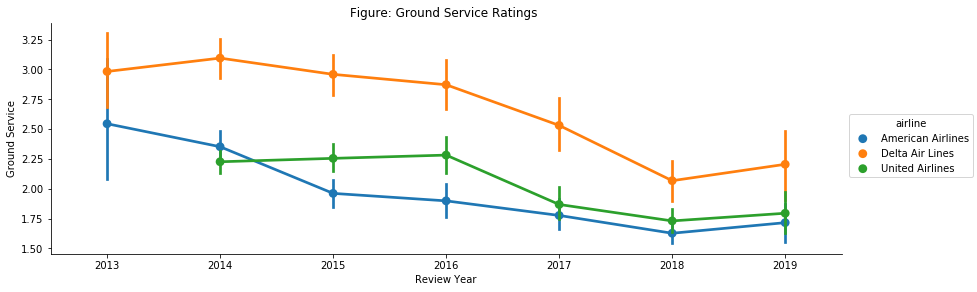

In [286]:
sns.factorplot(x='review_year', y='ground_service',data=DUA, height=6, aspect=3, hue='airline');
plt.xlabel('Review Year');
plt.ylabel('Ground Service');
plt.title("Figure: Ground Service Ratings ");

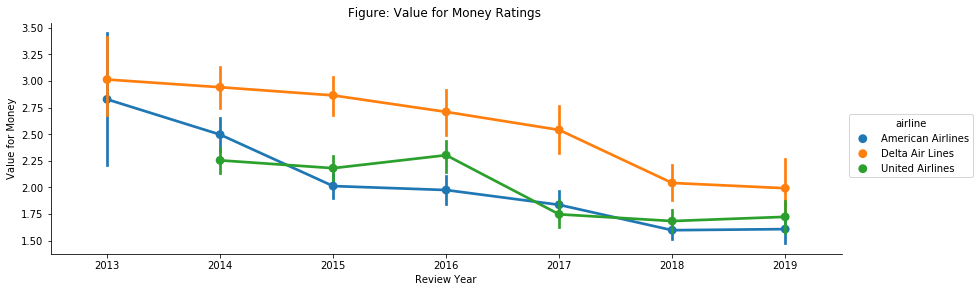

In [287]:
sns.factorplot(x='review_year', y='value_for_money',data=DUA, height=6, aspect=3, hue='airline');
plt.xlabel('Review Year');
plt.ylabel('Value for Money');
plt.title("Figure: Value for Money Ratings ");

# Time to dig into Customer Reviews Data

In [380]:
df_sky['clean_review'] = df_sky['customer_review'].apply(lambda x: x.split('|')[-1])
df_sky[['customer_review', 'clean_review']].head(25)

,customer_review,clean_review
0,âœ… Trip Verified | We were scheduled to fly f...,We were scheduled to fly from Miami to Orland...
1,Not Verified | I had a flight from Dallas to S...,I had a flight from Dallas to San Diego and i...
2,Not Verified | Pittsburgh to Tampa. Every sing...,Pittsburgh to Tampa. Every single time I try ...
3,âœ… Trip Verified | Dallas to Atlanta. You hav...,Dallas to Atlanta. You have to love a airline...
4,âœ… Trip Verified | Tampa to Vancouver via Dal...,Tampa to Vancouver via Dallas. Our first flig...
5,Not Verified | So disappointed with American A...,So disappointed with American Airlines. We ha...
6,Not Verified | We took off from New York Monda...,We took off from New York Monday evening with...
7,Not Verified | Fresno to Bradley. Flight was c...,Fresno to Bradley. Flight was canceled twice ...
8,âœ… Trip Verified | Los Angeles to Puerto Vall...,Los Angeles to Puerto Vallarta. Went to get o...
9,âœ… Trip Verified | Chicago to London. The wor...,Chicago to London. The worst company ever. Th...


In [309]:
stopwords = set(STOPWORDS)

In [397]:
def show_wordcloud(data, title, f_name):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=80,
        max_font_size=40, 
        scale=4,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    #plt.savefig(f_name, bbox_inches = 'tight');
    plt.show()
    plt.close(fig)


#Data Cleaning

def clean_reviewtext(mytext):
    review_text = str(list(mytext)).lower()
    text = re.sub(r"[^a-zA-Z0-9]", " ", review_text) 
    return text


# Create Cloud
def create_cloud(df, title, f_name):
    text = clean_reviewtext(df['clean_review'])
    show_wordcloud(text, title, f_name)
    #plt.savefig('a_cloud.png', bbox_inches = 'tight');


def generate_cloud(df):
    negative_reviews = df[df['overall'].isin([1,2])]
    neutral_reviews =  df[df['overall'].isin([3])]
    positive_reviews = df[df['overall'].isin([4,5])]

    create_cloud(positive_reviews, 'Positive Reviews WordCloud with Overall Rating 4 or 5', 'pos_cloud.png')
    create_cloud(negative_reviews,'Negative Reviews WordCloud with Overall Rating 1 or 2', 'neg_cloud.png')
    create_cloud(neutral_reviews,'Neutral Reviews WordCloud with Overall Rating 3', 'neut_cloud.png')



    negative_vectorizer = TfidfVectorizer(stop_words=STOPWORDS, ngram_range=(3, 3), 
                           max_df=1.0, min_df=1, max_features=3000,use_idf=False)
    negative_vectorized = negative_vectorizer.fit_transform(negative_reviews.clean_review)

    positive_vectorizer = TfidfVectorizer(stop_words=STOPWORDS, ngram_range=(3, 3), 
                           max_df=1.0, min_df=1, max_features=3000,use_idf=False)
    positive_vectorized = positive_vectorizer.fit_transform(positive_reviews.clean_review)

    neutral_vectorizer = TfidfVectorizer(stop_words=STOPWORDS, ngram_range=(3, 3), 
                           max_df=1.0, min_df=1, max_features=3000,use_idf=False)
    neutral_vectorized = neutral_vectorizer.fit_transform(neutral_reviews.clean_review)


    print("negative_vectorized", negative_vectorized.shape)
    print("positive_vectorized", positive_vectorized.shape)
    print("neutral_vectorized", neutral_vectorized.shape)
    
    
    #Most Common Comments from Positive Reviews


    positive_vocab = positive_vectorizer.get_feature_names()
    positive_vectorized_df = pd.DataFrame(positive_vectorized.todense(),columns=[positive_vocab]).sum()
    positive_term_f = positive_vectorized_df.sort_values(ascending=False)
    print("positive_term_frequency", positive_term_f.head(15))

    #Most Common Comments from Negative Reviews

    negative_vocab = negative_vectorizer.get_feature_names()
    negative_vectorized_df = pd.DataFrame(negative_vectorized.todense(),columns=[negative_vocab]).sum()
    negative_term_f = negative_vectorized_df.sort_values(ascending=False)
    print("negative_term_frequency", negative_term_f.head(15))


    #Most Common Comments from Neutral Reviews

    neutral_vocab = neutral_vectorizer.get_feature_names()
    neutral_vectorized_df = pd.DataFrame(neutral_vectorized.todense(),columns=[neutral_vocab]).sum()
    neutral_term_f = neutral_vectorized_df.sort_values(ascending=False)
    print("neutral_term_frequency", neutral_term_f.head(15))


    #Create Visualizations

    df_pos = pd.DataFrame(positive_term_f)
    df_neg = pd.DataFrame(negative_term_f)
    df_neut = pd.DataFrame(neutral_term_f)

    #df_pos.head(10).plot(kind='bar', title='Positive Reviews', );
    #df_neg.head(10).plot(kind='bar', title='Negative Reviews', );

    #fig = plt.figure(figsize=(9, 11));




    #df_neg.head(7).plot(kind='barh', title='Negative Reviews', figsize=(6,4))
    #plt.savefig('plot2.png', bbox_inches = 'tight');
    #plt.close(fig)

    df_pos_top = df_pos.reset_index().head(10)
    df_pos_top.columns = ['content', 'value']
    df_pos_top.plot(x='content', kind='barh', title='Positive Reviews', figsize=(6,4), color='green')
    plt.xlabel('Frequency')
    plt.ylabel('Most Frequent Context')
    #plt.savefig('plot1.png', bbox_inches = 'tight');
    #plt.close(fig)



    df_neg_top = df_neg.reset_index().head(10)
    df_neg_top.columns = ['content', 'value']
    df_neg_top.plot(x='content', kind='barh', title='Negative Reviews', figsize=(6,4), color='red')
    plt.xlabel('Frequency')
    plt.ylabel('Most Frequent Context')
    #plt.savefig('plot2.png', bbox_inches = 'tight');


    df_neut_top = df_neut.reset_index().head(10)
    df_neut_top.columns = ['content', 'value']
    df_neut_top.plot(x='content', kind='barh', title='Neutral Reviews', figsize=(6,4), color='orange')
    plt.xlabel('Frequency')
    plt.ylabel('Most Frequent Context')
    #plt.savefig('plot1.png', bbox_inches = 'tight');
    #plt.close(fig)



## Generating Word Cloud On all customer_review data

Generating Word Cloud On all customer_review data


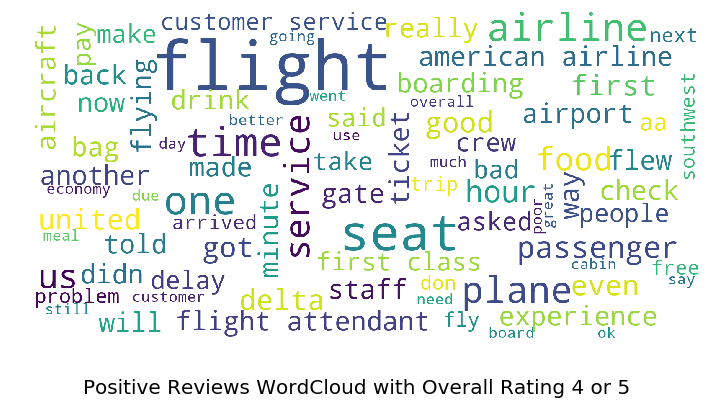

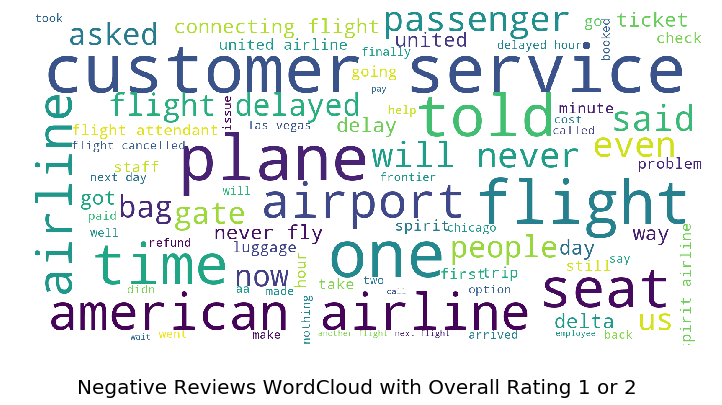

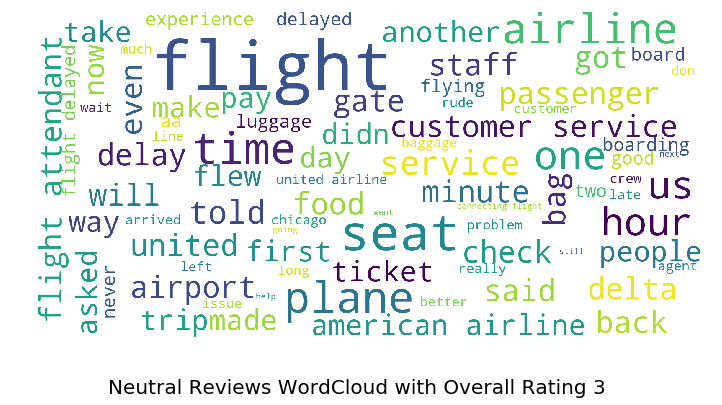

negative_vectorized (8614, 3000)
positive_vectorized (658, 3000)
neutral_vectorized (706, 3000)
positive_term_frequency delta air lines              7.138595
new york jfk                 6.810143
first time flying            4.307518
salt lake city               4.301960
dallas ft worth              4.223298
american airlines flight     3.938519
flight attendants rude       3.861427
via san francisco            3.747646
service flight attendants    3.311450
business class seats         3.078416
flight delayed hours         3.069503
will never fly               2.950274
flight delayed hour          2.757658
delayed hours due            2.546259
will fly southwest           2.443376
dtype: float64
negative_term_frequency will never fly               420.182125
flight delayed hours         107.791343
never fly spirit              99.346438
never fly airline             82.854017
never fly united              77.063387
fly american airlines         74.698039
salt lake city                7

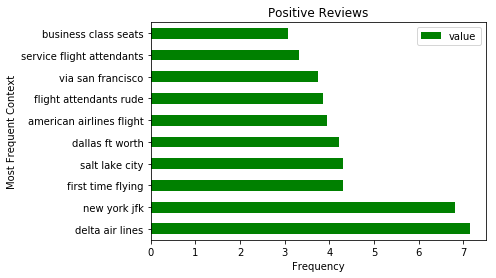

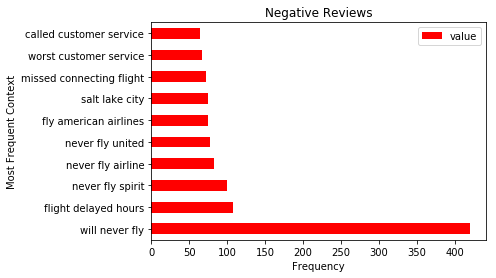

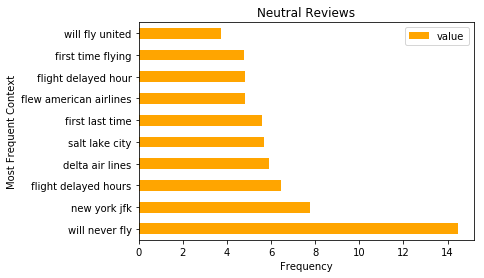

In [398]:
generate_cloud(df_sky)


## Generating Word Cloud Only Delta Airlines customer_review data

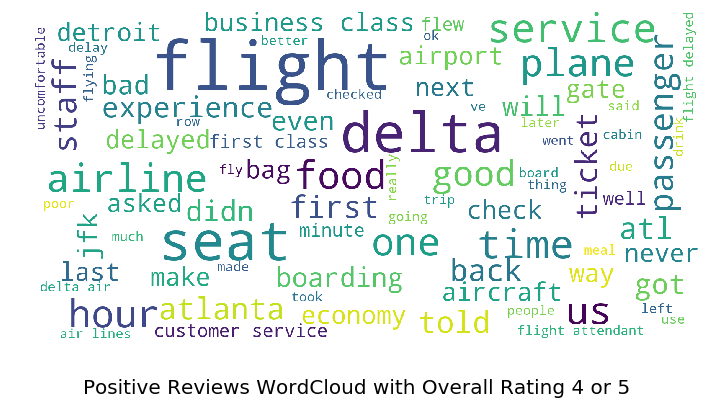

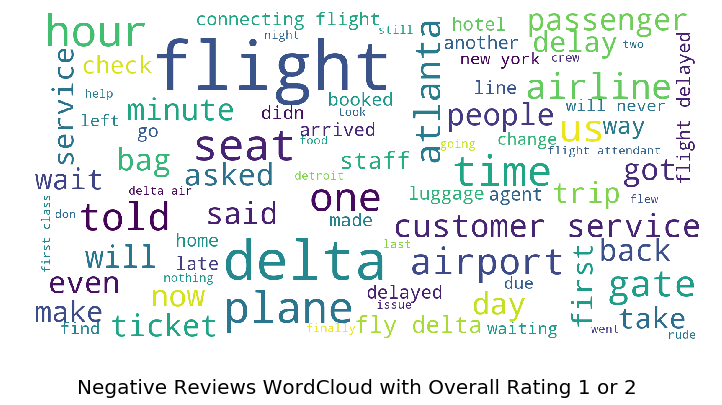

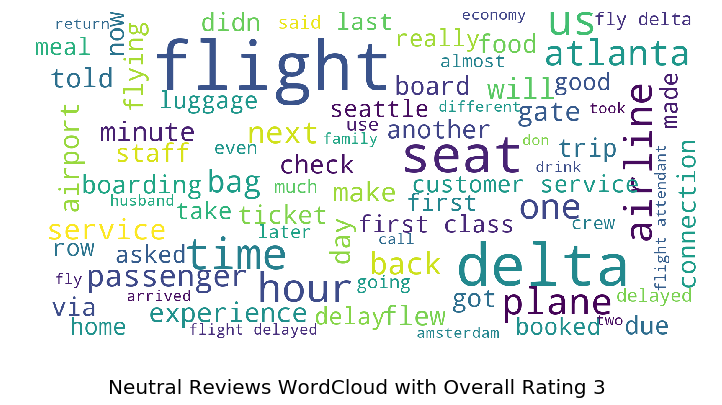

negative_vectorized (662, 3000)
positive_vectorized (110, 3000)
neutral_vectorized (117, 3000)
positive_term_frequency delta air lines              3.350747
salt lake city               1.256776
business class seats         0.819042
customer service flight      0.723162
york delta air               0.610683
new york delta               0.610683
atl sju segments             0.603023
new york jfk                 0.587307
service flight attendants    0.558763
never fly delta              0.545508
missing connecting flight    0.511595
first class seat             0.500957
medical condition chronic    0.500000
via atlanta displeased       0.500000
man seemed healthy           0.500000
dtype: float64
negative_term_frequency delta air lines              30.030406
will never fly               25.146813
never fly delta              21.757004
salt lake city               17.645404
new york jfk                  8.574805
delta customer service        6.919166
horrible customer service     6.468402

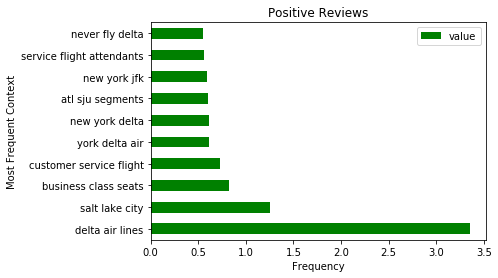

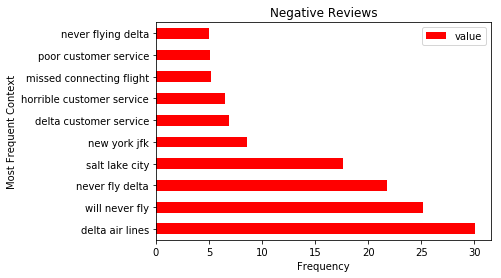

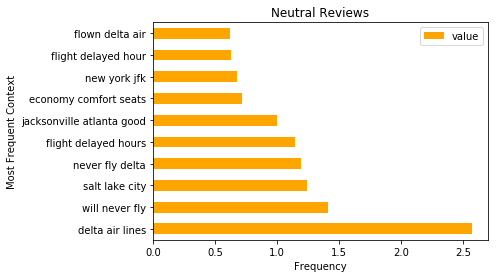

In [403]:
generate_cloud(DUA[DUA['airline_no']==2])


## Generating Word Cloud Only United Airlines customer_review data

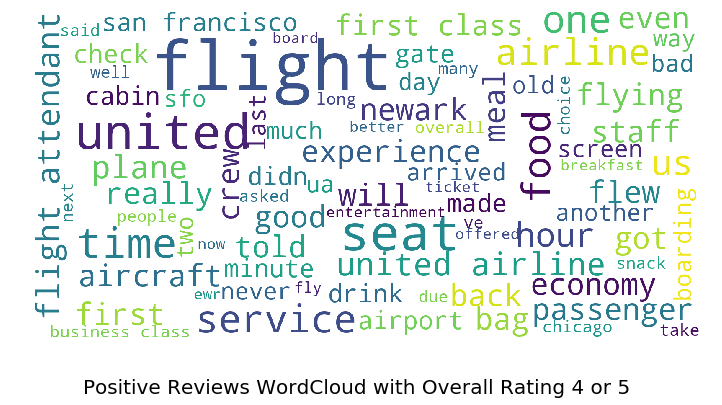

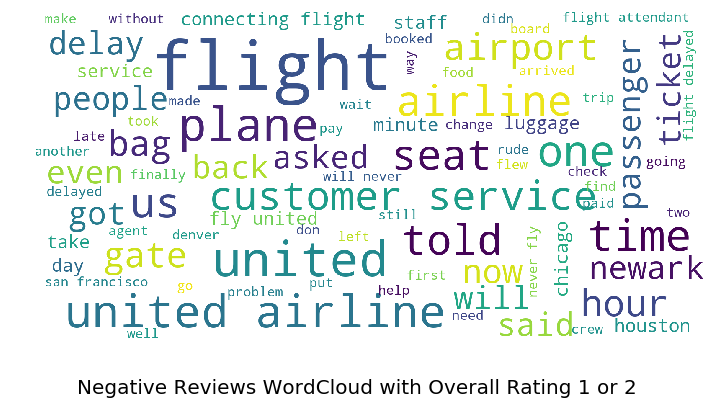

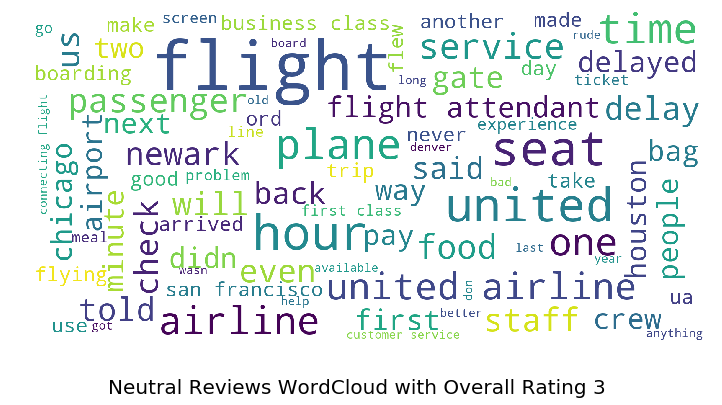

negative_vectorized (1851, 3000)
positive_vectorized (181, 3000)
neutral_vectorized (196, 3000)
positive_term_frequency via san francisco             2.363365
fasten seatbelt sign          1.347733
flew united airlines          1.326254
san francisco united          1.122049
long haul flights             1.052782
long haul flight              0.959054
flights time seats            0.957107
flight united airlines        0.955315
united airlines flight        0.904925
flew san francisco            0.891017
will never fly                0.853685
united first class            0.842548
united airlines washington    0.816228
first class cabin             0.785890
26 april 2014                 0.727607
dtype: float64
negative_term_frequency will never fly                73.931371
never fly united              70.095694
fly united airlines           25.958795
missed connecting flight      18.681923
flight delayed hours          18.113002
via san francisco             17.391122
united airlines 

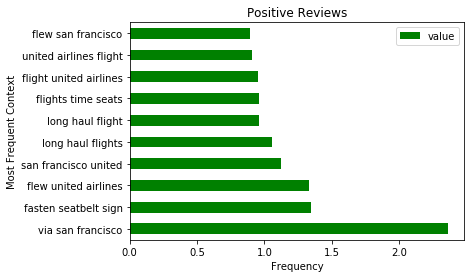

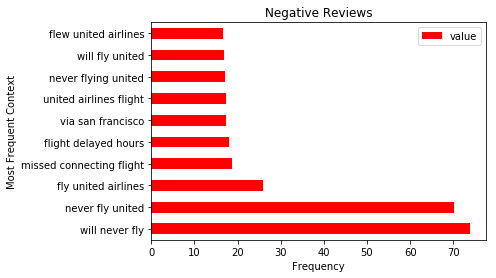

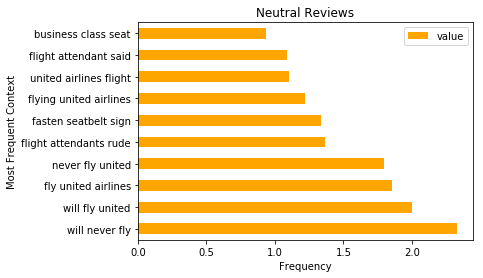

In [404]:
generate_cloud(DUA[DUA['airline_no']==4])




## Generating Word Cloud Only American Airlines customer_review data

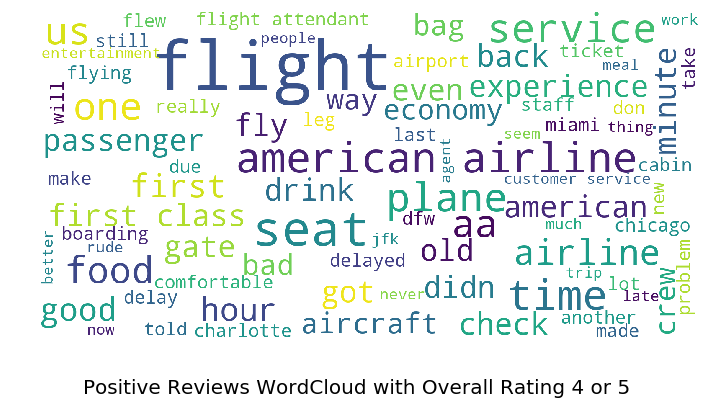

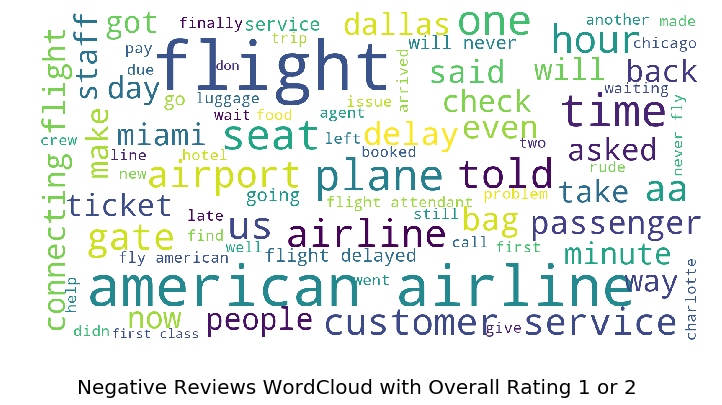

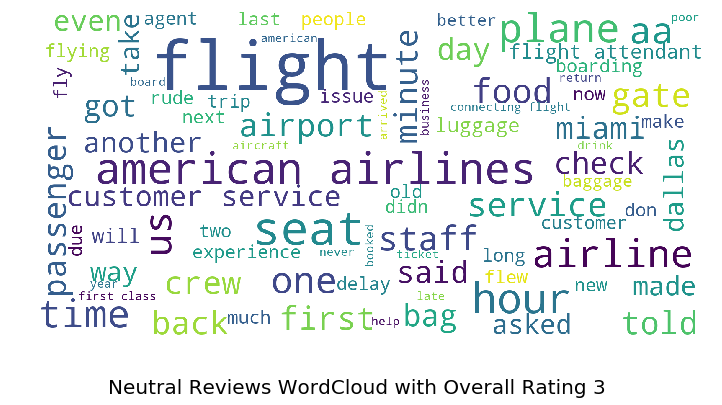

negative_vectorized (1965, 3000)
positive_vectorized (159, 3000)
neutral_vectorized (178, 3000)
positive_term_frequency new york jfk                      2.576689
american airlines flight          2.144103
dallas ft worth                   1.882506
miami american airlines           1.192777
flew american airlines            1.088921
london new york                   1.044064
first class seats                 0.960660
american airlines staff           0.861714
jfk american airlines             0.777350
philadelphia american airlines    0.769729
chicago american airlines         0.751534
seat belt sign                    0.748409
never fly american                0.728400
make connecting flight            0.726605
miami port spain                  0.707107
dtype: float64
negative_term_frequency will never fly                  79.248186
fly american airlines           66.361221
never fly american              50.631974
dallas ft worth                 34.499402
american airlines flight    

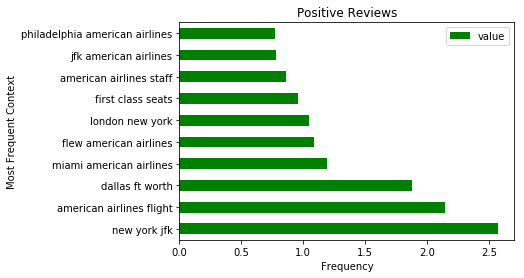

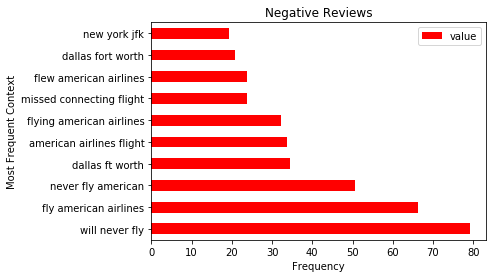

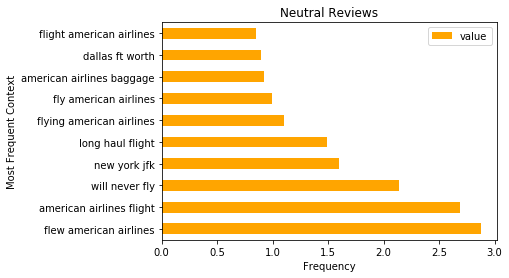

In [405]:
generate_cloud(DUA[DUA['airline_no']==1])



# End Here - Rough Work Below

In [ ]:
# Getting data in SQL form
import sqlite3

# connect to the database
conn = sqlite3.connect('population_data.db')

# run a query
pd.read_sql('SELECT * FROM population_data', conn)

In [25]:
# Fixing overall rating values

#working_df.to_sql('data', connection,index=False, if_exists='append')


skytrax.to_sql('skytrax_data', connection, index=False, if_exists='replace')

In [28]:
pd.read_sql("SELECT count(1) FROM skytrax_data where overall == 5", sql_engine)

,count(1)
0,336
